# Ensemble Learning Exercise

## 1. Implementing Random Forest From Scratch (30 points)
In this exercise you will need to implement a simple version of Random Forest Regressor from scratch. Your model will handle **continuous input and output**. 

1.1. Compelete the skeleton class below (you should use scikit-learn's `DecisionTreeRegressor` model that the `TreeEnsemble` will use)
  - `X` is a matrix of data values (rows are samples, columns are attributes)
  - `y` is a vector of corresponding target values
  - `n_trees` is the number of trees to create
  - `sample_sz` is the size of the sample set to use of each of the trees in the forest (chose the samples randomly, with or without repetition)
  - `n_features` is the size of features to sample. This can be a natrual number > 0, or a ratio of the features as a number in range (0,1]
  - `min_leaf` is the minimal number of samples in each leaf node of each tree in the forest
  

1.2. The `predict` function will use mean of the target values of the trees. The result is a vector of predictions matching the number of rows in `X`.

1.3. The `oob_mse` function will compute the mean squared error over all **out of bag (oob)** samples. That is, for each sample calculate the squared error using  predictions from the trees that do not contain x in their respective bootstrap sample, then average this score for all samples. See:  [OOB Errors for Random Forests](https://scikit-learn.org/stable/auto_examples/ensemble/plot_ensemble_oob.html).

1.4. To check your random forest implementation, use the boston dataset (`from sklearn.datasets import load_boston`)

  - Use the following to estimate what are the best hyper parameters to use for your model
```
for n in [1,5,10,20,50,100]:
  for sz in [50,100,300,500]:
    for min_leaf in [1,5]:
      forest = TreeEnsemble(X, y, n, sz, min_leaf)
      mse = forest.oob_mse()
      print("n_trees:{0}, sz:{1}, min_leaf:{2} --- oob mse: {3}".format(n, sz, min_leaf, mse))
```
  
  - Using your chosen hyperparameters as a final model, plot the predictions vs. true values of all the samples in the training set . Use something like:
  ```
  y_hat = forest.predict(X)  # forest is the chosen model
  plt.scatter(y_hat, y)
  ```
 


In [28]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
import warnings


def isin2D(full_array, sub_arrays): 
    out = np.zeros((sub_arrays.shape[0],len(full_array)),dtype=bool)
    np.put_along_axis(out, sub_arrays, sub_arrays == sub_arrays, axis=1)
    return out

class TreeEnsemble():
    def __init__(self, X, y, n_trees=50, sample_sz=None, n_features=None, min_leaf=1):
        
        n , d = X.shape
        
        self.X = X
        self.n_trees = n_trees
        self.sample_sz = self.fraction_or_count(sample_sz, n)
        self.n_features = self.fraction_or_count(n_features, d)
        self.min_leaf = min_leaf
        
        self.trees = []
        samples = []
        i = 0
        
        for samp in self.sample(seed=i):
            samples.append(samp)
            t = DecisionTreeRegressor(random_state=i, min_samples_leaf=self.min_leaf, max_features=n_features, splitter='random').fit(X[samp], y[samp])
            i +=1
            self.trees.append(t)

        mask = isin2D(np.arange(n), np.array(samples))
        predictions = self._predict_all(X)
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)
            oob_pred = predictions.mean(where=~mask, axis=0)
        self.oob_mse_score = mean_squared_error(y[~np.isnan(oob_pred)], oob_pred[~np.isnan(oob_pred)])
        

    def _predict_all(self, X):
        return np.array([t.predict(X) for t in self.trees])


    def predict(self, X):
        return self._predict_all(X).mean(axis=0)

    def oob_mse(self):
        return self.oob_mse_score

    def sample(self, seed):
        rng = np.random.default_rng(seed)
        for _ in range(self.n_trees):
            yield rng.choice(len(self.X), size=self.sample_sz, replace=True)


    def fraction_or_count(self, quantity, ref):
        if isinstance(quantity, float):
            return int(quantity * ref)
        elif isinstance(quantity, int):
            return quantity
        elif isinstance(quantity, type(None)):
            return int(ref ** 0.5)

    def __repr__(self) -> str:
        return f'Random Forest: n_trees={self.n_trees}, sample_sz={self.sample_sz}, n_features={self.n_features}, min_leaf={self.min_leaf}'

In [24]:
from sklearn.datasets import load_boston
X, y = load_boston(return_X_y=True)

c:\Program Files\Anaconda3\envs\py4dp\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np

        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housi

In [27]:
best_mse = float('inf')
best_forest = None
for n in [1,5,10,20,50,100]:
  for sz in [50,100,300,500]:
    for min_leaf in [1,5]:
      forest = TreeEnsemble(X, y, n, sz, min_leaf)
      mse = forest.oob_mse()
      if mse < best_mse:
        best_forest = forest
        best_mse = mse
      print("n_trees:{0}, sz:{1}, min_leaf:{2} --- oob mse: {3}".format(n, sz, min_leaf, mse))

print(f'\n\nBest MSE: {best_mse} for {best_forest}')


n_trees:1, sz:50, min_leaf:1 --- oob mse: 68.56793859649123
n_trees:1, sz:50, min_leaf:5 --- oob mse: 59.56673245614035
n_trees:1, sz:100, min_leaf:1 --- oob mse: 99.084039408867
n_trees:1, sz:100, min_leaf:5 --- oob mse: 37.59177339901478
n_trees:1, sz:300, min_leaf:1 --- oob mse: 49.58878640776699
n_trees:1, sz:300, min_leaf:5 --- oob mse: 30.857087378640784
n_trees:1, sz:500, min_leaf:1 --- oob mse: 28.90166666666667
n_trees:1, sz:500, min_leaf:5 --- oob mse: 33.28333333333334
n_trees:5, sz:50, min_leaf:1 --- oob mse: 45.11369824879227
n_trees:5, sz:50, min_leaf:5 --- oob mse: 27.165127684453225
n_trees:5, sz:100, min_leaf:1 --- oob mse: 41.108122633948184
n_trees:5, sz:100, min_leaf:5 --- oob mse: 21.47974938515591
n_trees:5, sz:300, min_leaf:1 --- oob mse: 37.64871923890063
n_trees:5, sz:300, min_leaf:5 --- oob mse: 25.90668811956777
n_trees:5, sz:500, min_leaf:1 --- oob mse: 24.482844827586213
n_trees:5, sz:500, min_leaf:5 --- oob mse: 23.048275862068966
n_trees:10, sz:50, min_le

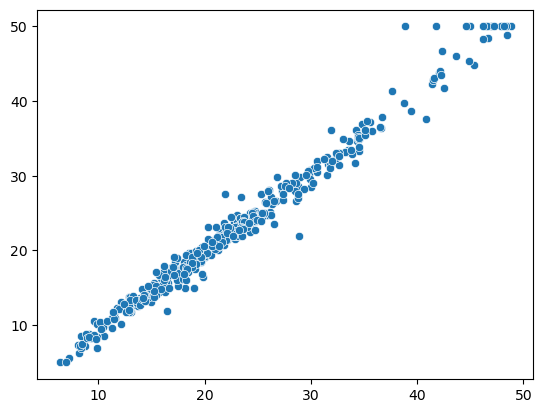

In [29]:
import seaborn as sns
y_hat = best_forest.predict(X)
sns.scatterplot(x=y_hat, y=y);


## 2. Implementing AdaBoost From Scratch (30 points)


2.1.   Implement the AdaBoost algorithm for classification task. Your `AdaBoost` class should receive a method for creating a weak learner, which has a fit and predict methods (**hint**: you can simulate re-weighting of the samples by an appropriate re-sampling of the train set).

2.2.   Use your model to find a strong classifier on the sample set given below, using $n$ weak learners:

2.2.1. For the base weak learners, use any classifier you want (check different types with different configuration, keep them simple = Weak). 

2.2.2. Split the sample set into train and test sets.

2.2.3 Plot the final decision plane of your classifier for $n\in \{1, 2, 3, 5, 10, 50\}$, and visualize the final iteration weights of the samples in those plots.
    - How does the overall train set accuracy changes with $n$?
    - Does you model starts to overfit at some point?





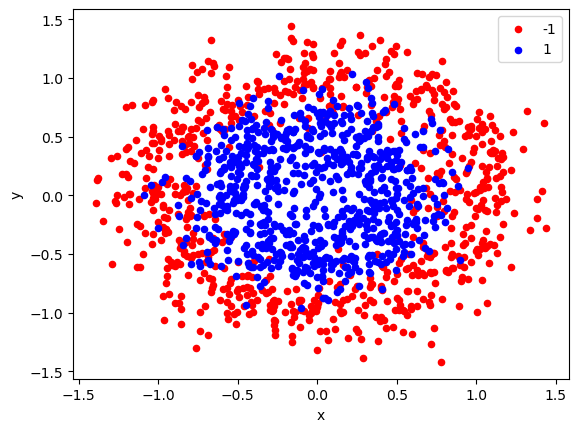

In [18]:
from sklearn.datasets import make_circles
from matplotlib import pyplot
from pandas import DataFrame

# generate 2d classification dataset
X, y = make_circles(n_samples=1500, noise=0.2, random_state=101, factor=0.5)
y[y==0] = -1

# scatter plot, dots colored by class value
df = DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
colors = {-1:'red', 1:'blue'}
fig, ax = pyplot.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
pyplot.show()

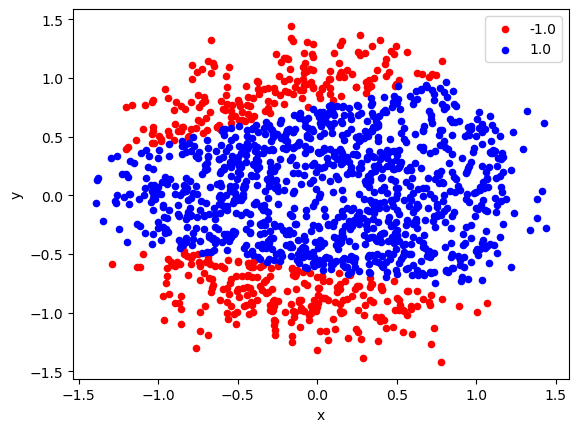

In [20]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.exceptions import ConvergenceWarning
from sklearn.utils._testing import ignore_warnings

def stump(seed=0):
    return DecisionTreeClassifier(max_depth=1, random_state=seed, splitter='random')

def dumb(seed=0):
    return SGDClassifier(max_iter=1, random_state=seed, )

class AdaBoost():

    def __init__(self, learner_generator=stump, n_learners=50, max_epochs=100):
        
        self.max_epochs = max_epochs
        self.n_learners = n_learners
        self.learner_generator = learner_generator
        self.learners = []
        self.alphas = []

    @ignore_warnings(category=ConvergenceWarning)
    def fit(self, X, y):

        n = len(y)
        
        self.D = np.full_like(y, 1/n, dtype='float')

        for i in range(self.n_learners):
            
            lt = self.learner_generator(i).fit(X,y)
            y_pred = lt.predict(X)
            self._adjust_weights(y, y_pred)
            self.learners.append(lt)

        return self

    def _adjust_weights(self, y, y_pred):
        err = ((y != y_pred) * self.D).sum()

        alpha = np.log((1 - err) / err) / 2
        self.alphas.append(alpha)

        self.D *= (np.exp(-alpha * y * y_pred) / self.D.sum())


    def predict(self, X):
        return np.sign(np.array([a * l.predict(X) for a, l in zip(self.alphas, self.learners)]).sum(axis=0))
        


def plot_stuff(X, y_pred):
    df = DataFrame(dict(x=X[:,0], y=X[:,1], label=y_pred))
    colors = {-1:'red', 1:'blue'}
    fig, ax = pyplot.subplots()
    grouped = df.groupby('label')
    for key, group in grouped:
        group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])


y_pred = AdaBoost(learner_generator=dumb, n_learners=10).fit(X,y).predict(X)
plot_stuff(X, y_pred)


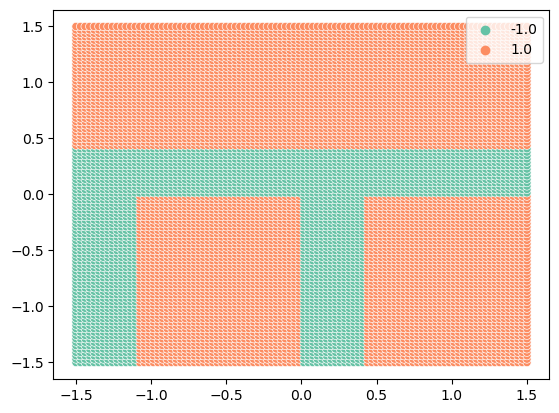

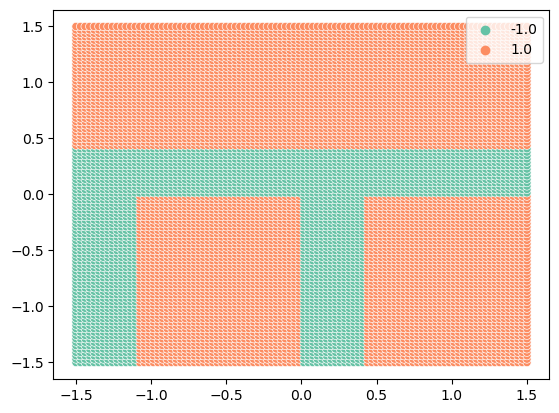

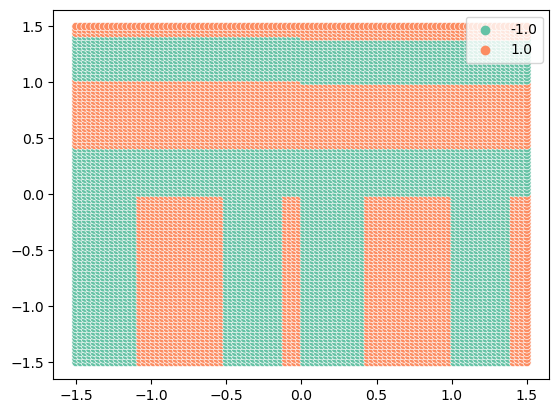

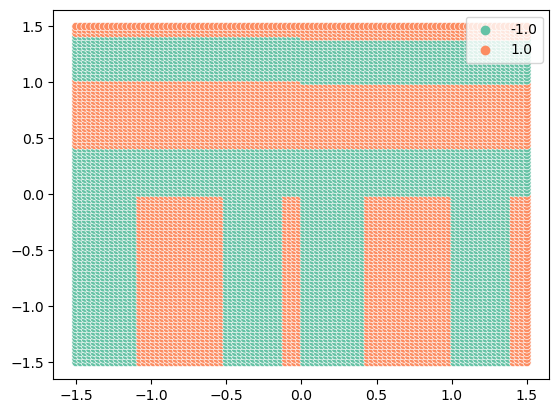

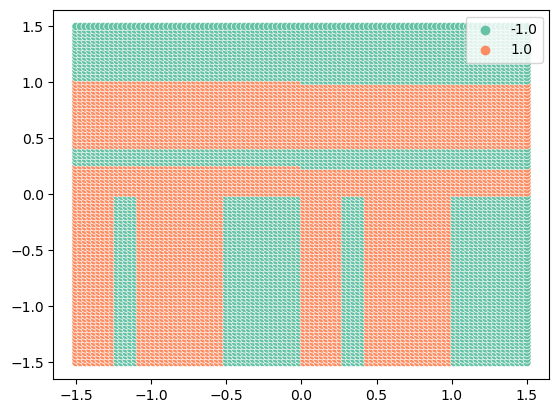

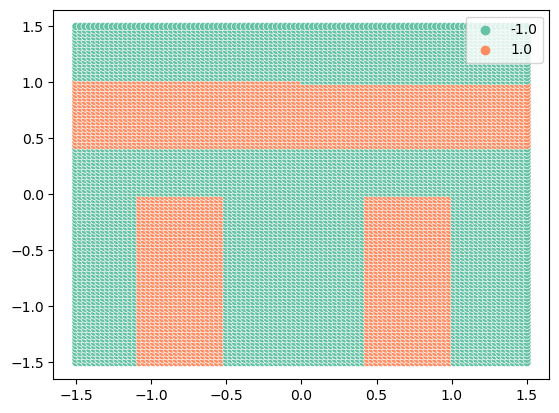

In [21]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt 

X_train, X_test, y_train, y_test = train_test_split(X, y)

for n in [1, 2, 3, 5, 10, 50]:
    cls = AdaBoost(learner_generator=dumb, n_learners=n).fit(X_train, y_train)
    xv,yv = np.meshgrid(np.linspace(-1.5,1.5,100), np.linspace(-1.5,1.5,100))
    sns.scatterplot(x=xv.flatten(), y=yv.flatten(), hue=cls.predict(np.vstack([xv,yv]).reshape((-1,2))), palette='Set2')
    plt.show()
    # y_pred = cls.predict(X_test)
    


## 3. Boosting Trees from Scratch (40 points)
1. Use the scikit-learn's DecisionTreeRegressor (again :) with `max_depth = 1` (stumps)  to write a L2Boost model which minimize the L2 square loss iteration by iteration.
Reminder: in each step, build a decision tree to minimize the error between the true label and the accumulated (sum) of the previous step predictions.
![alt text](https://explained.ai/gradient-boosting/images/latex-321A7951E78381FB73D2A6874916134D.svg)
2. Use the Boston dataset to plot the MSE as a function of the number of trees for a logspace of `n_trees` up to 1,000. What is the optimal value of `n_trees`? of learning rate?
3. Compare the performance with a deep DecisionTreeRegressor (find the optimal `max_depth`).  Who wins?
4. Add an early-stopping mechanisim to the GBTL2 model to use a validation set to detect over-fit.

In [ ]:
class L2Boost(object):

    def __init__():
        pass

    def fit(self, X, y, M, lr):
        F =  y.mean()
        for m in range(M):
            r = y - F
            stump = DecisionTreeRegressor(splitter='random', max_depth=1).fit(X, r)
            F = F + lr*stump.predict(X)
        
        self.F = F
    
    def predict(self, X):
        return self.F.predict(X)

